# 1. Introduction
In this jupyter notebook we will perfrom clustering of cryptocurrencies into different groups for 
further choosing of 10 random samples from each group. 
The clustering is executed using the following methods: 
- K-means
- Affinity Propagation

# 2. Loading data and python packages
## 2.1 Loading the python packages

In [73]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle
from datetime import datetime
import os
import random

In [21]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [22]:
import sys 
sys.path.append('../utilities')

In [23]:
from MlDataPreparer import MlDataPreparer

## 2.2. Loading the data

In [114]:
parent_folder = "../hist_data"
tickers = (os.listdir(parent_folder))

In [115]:
dataPreparer = MlDataPreparer()

In [122]:
def select_active_tickers(ref_date="2022-11-10", delta=7):
    tickers_dic = {}    
    filter_lst = [".DS_Store", ".ipynb_checkpoints", "UP", "DOWN"]
    
    for ticker in tickers: 
        if not any(no_ticker in ticker for no_ticker in filter_lst):
            dataPreparer.load_data(ticker)
            df = dataPreparer.data.copy()
            days = (datetime.strptime(ref_date, "%Y-%m-%d") - df.index[-1]).days
            tickers_dic[ticker] = days

    df = pd.DataFrame(tickers_dic.items(), columns=["tickers", "delta"])
    return df

In [123]:
tickers_df = select_active_tickers()

In [129]:
def load_active_ticker_data():
    nums = 500
    close_df = pd.DataFrame(range(nums))
    count = 0
    for ticker in tickers_df.tickers.tolist():
        dataPreparer.load_data(ticker)
        data = dataPreparer.data.resample("1d").last().reset_index(drop=True)
        if len(data) > nums and ticker not in close_df.columns:
            ticker_data = data.Close.iloc[-nums:].tolist()
            close_df.insert(loc=0, column=ticker, value=ticker_data)
        
    return close_df

In [130]:
dataset = load_active_ticker_data()

# 3. Exploratory Data Analysis

Let's look at the dataset.

## 3.1. Descriptive Statistics
The following steps will performed to get some basic knowlegde about the data:

- Viewing the raw data.
- Reviewing the dimensions of the dataset.
- Reviewing the data types of attributes.

In [131]:
# shape
dataset.shape

(500, 239)

In [132]:
# peek at data
dataset.head(2)

,DEGOUSDT,JUVUSDT,USDTRUB,USDTDAI,TUSDUSDT,LTCUSDT,ROSEUSDT,RENUSDT,WTCUSDT,BNTUSDT,...,BCHUSDT,USDTTRY,TOMOUSDT,OGUSDT,CRVUSDT,SUNUSDT,STORJUSDT,MDTUSDT,DREPUSDT,0
0,4.62,7.20,72.84,1.0,1.0,134.59,0.05,0.34,0.47,2.90,...,460.79,8.80,1.33,3.96,1.46,0.02,0.60,0.02,0.36,0
1,4.75,7.44,73.02,1.0,1.0,127.14,0.06,0.33,0.53,2.79,...,446.81,8.83,1.30,4.03,1.46,0.02,0.62,0.02,0.33,1


In [133]:
# types
dataset.dtypes

DEGOUSDT     float64
JUVUSDT      float64
USDTRUB      float64
USDTDAI      float64
TUSDUSDT     float64
              ...   
SUNUSDT      float64
STORJUSDT    float64
MDTUSDT      float64
DREPUSDT     float64
0              int64
Length: 239, dtype: object

In [134]:
# remove the last column wiht index values
dataset = dataset.iloc[:, :-1]

In [135]:
# describe data
set_option('display.precision', 2)
dataset.describe()

,DEGOUSDT,JUVUSDT,USDTRUB,USDTDAI,TUSDUSDT,LTCUSDT,ROSEUSDT,RENUSDT,WTCUSDT,BNTUSDT,...,HBARUSDT,BCHUSDT,USDTTRY,TOMOUSDT,OGUSDT,CRVUSDT,SUNUSDT,STORJUSDT,MDTUSDT,DREPUSDT
count,500.00,500.00,500.00,5.00e+02,5.00e+02,500.00,500.00,500.00,500.00,500.00,...,500.00,500.00,500.00,500.00,500.00,500.00,5.00e+02,500.00,500.00,500.00
mean,4.68,7.54,71.75,1.00e+00,1.00e+00,116.22,0.17,0.41,0.55,2.31,...,0.20,345.37,13.91,1.47,4.70,2.28,1.71e-02,1.04,0.05,0.67
std,3.21,3.41,11.82,5.76e-04,5.89e-04,53.72,0.11,0.30,0.31,1.42,...,0.11,193.16,3.71,0.94,1.67,1.30,1.03e-02,0.48,0.02,0.19
min,0.87,2.19,53.33,9.96e-01,9.99e-01,43.70,0.04,0.09,0.13,0.41,...,0.06,98.30,8.22,0.38,1.23,0.58,4.96e-03,0.35,0.02,0.33
25%,1.84,4.94,61.92,1.00e+00,1.00e+00,60.52,0.06,0.14,0.28,0.55,...,0.07,133.43,9.62,0.55,3.52,1.19,6.56e-03,0.62,0.03,0.53
50%,3.41,6.33,73.00,1.00e+00,1.00e+00,112.63,0.13,0.34,0.49,2.44,...,0.21,325.55,14.58,1.21,4.17,2.12,1.47e-02,1.00,0.04,0.63
75%,7.19,10.22,74.75,1.00e+00,1.00e+00,153.40,0.25,0.57,0.90,3.51,...,0.27,514.85,17.46,2.29,5.91,2.88,2.49e-02,1.33,0.05,0.76
max,13.25,15.58,123.94,1.00e+00,1.00e+00,274.10,0.57,1.25,1.28,4.82,...,0.52,794.00,18.92,3.80,11.14,6.32,4.07e-02,2.88,0.15,1.47


## 3.2. Data Visualization

Taking a look at the correlation.<br>
Since we have the data of 257 cryptocurrencies in our dataset, we choose randomly a subset contaiing 50 cryptocurrencies to perform further visualization to gain insight in the relationship of choosen cryptocurrencies.

In [136]:
# create a subset our dataset containing only 50 columns
num = 50
subset_cols = random.sample(dataset.columns.to_list(), num)
data_subset = dataset.loc[:, subset_cols]

In [137]:
data_subset.head(2)

,BNTUSDT,CHRUSDT,UMAUSDT,CVCUSDT,RVNUSDT,OGUSDT,ADAUSDT,PAXGUSDT,REPUSDT,DASHUSDT,...,DATAUSDT,AVAUSDT,WINUSDT,SUNUSDT,XMRUSDT,ICPUSDT,XEMUSDT,JUVUSDT,BLZUSDT,TRUUSDT
0,2.90,0.13,7.68,0.18,0.05,3.96,1.39,1777.34,11.31,123.71,...,0.11,2.11,3.73e-04,0.02,198.64,49.85,0.11,7.20,0.12,0.15
1,2.79,0.13,7.91,0.18,0.05,4.03,1.37,1780.63,11.82,122.10,...,0.12,2.24,3.69e-04,0.02,197.69,56.93,0.12,7.44,0.13,0.16


<AxesSubplot:title={'center':'Correlation Matrix'}>

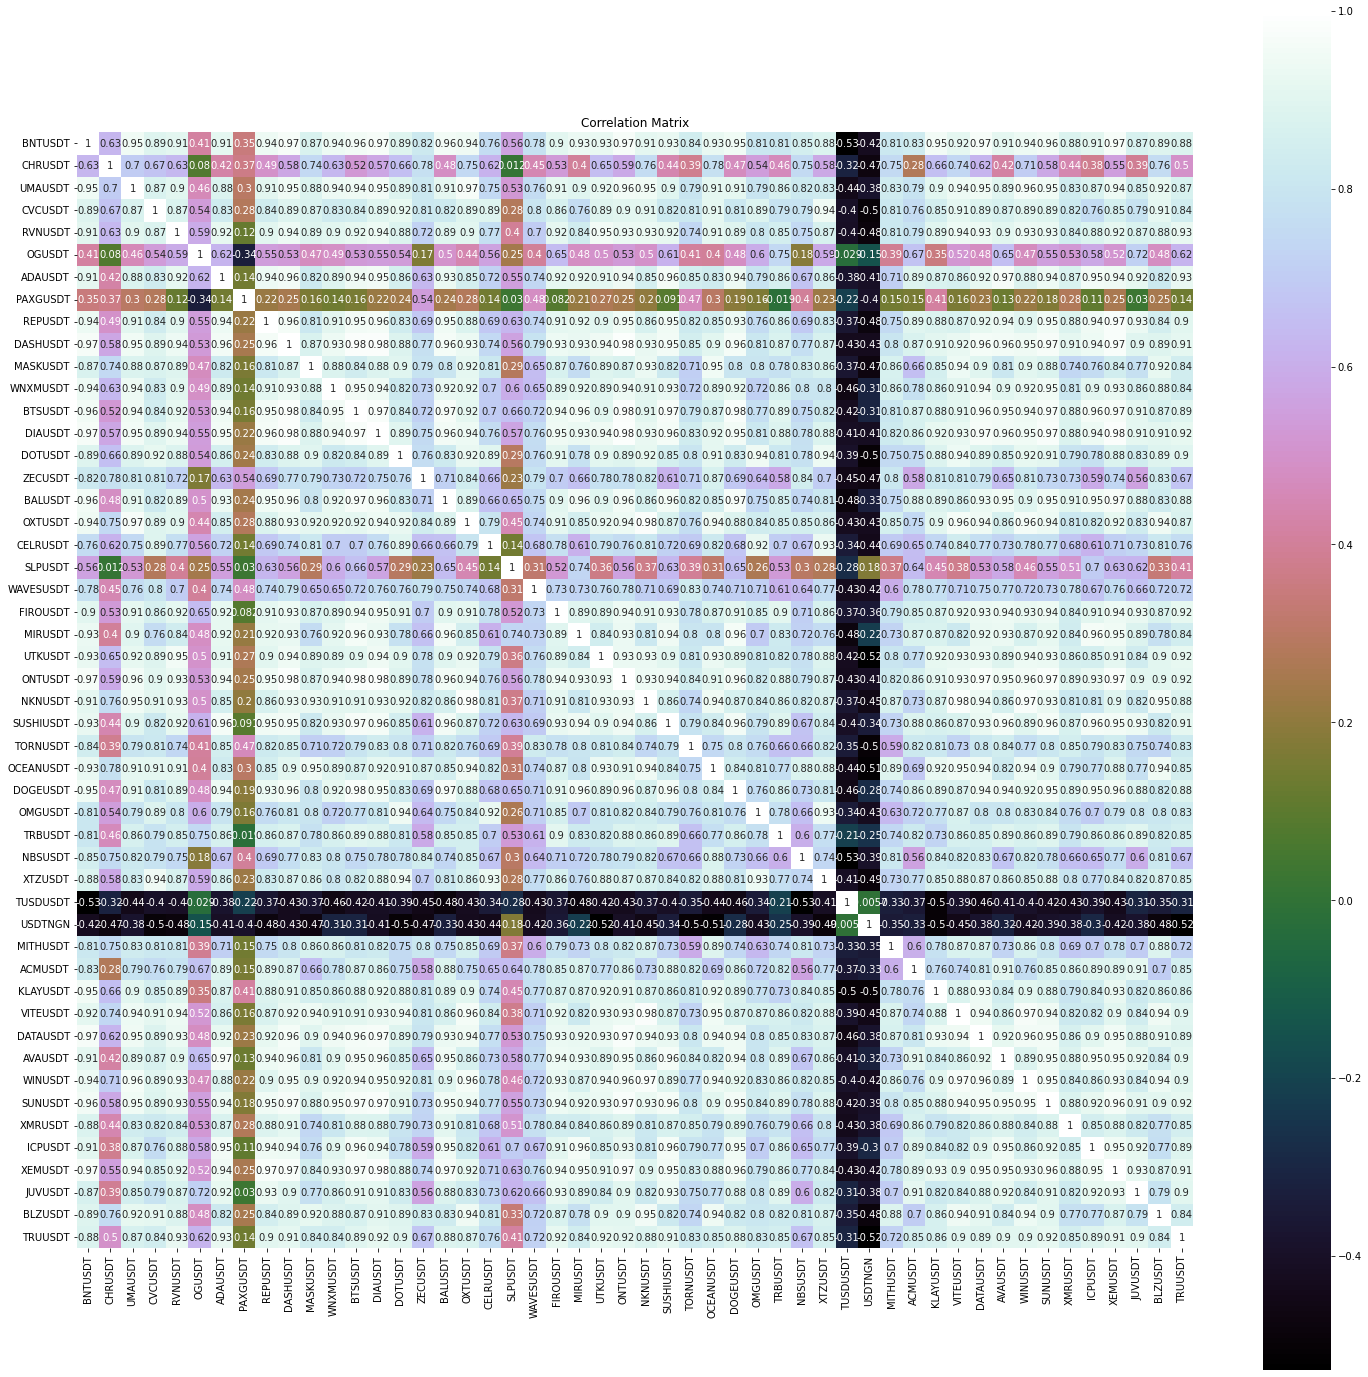

In [138]:
# correlation
correlation = data_subset.corr()
plt.figure(figsize=(25, 25))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

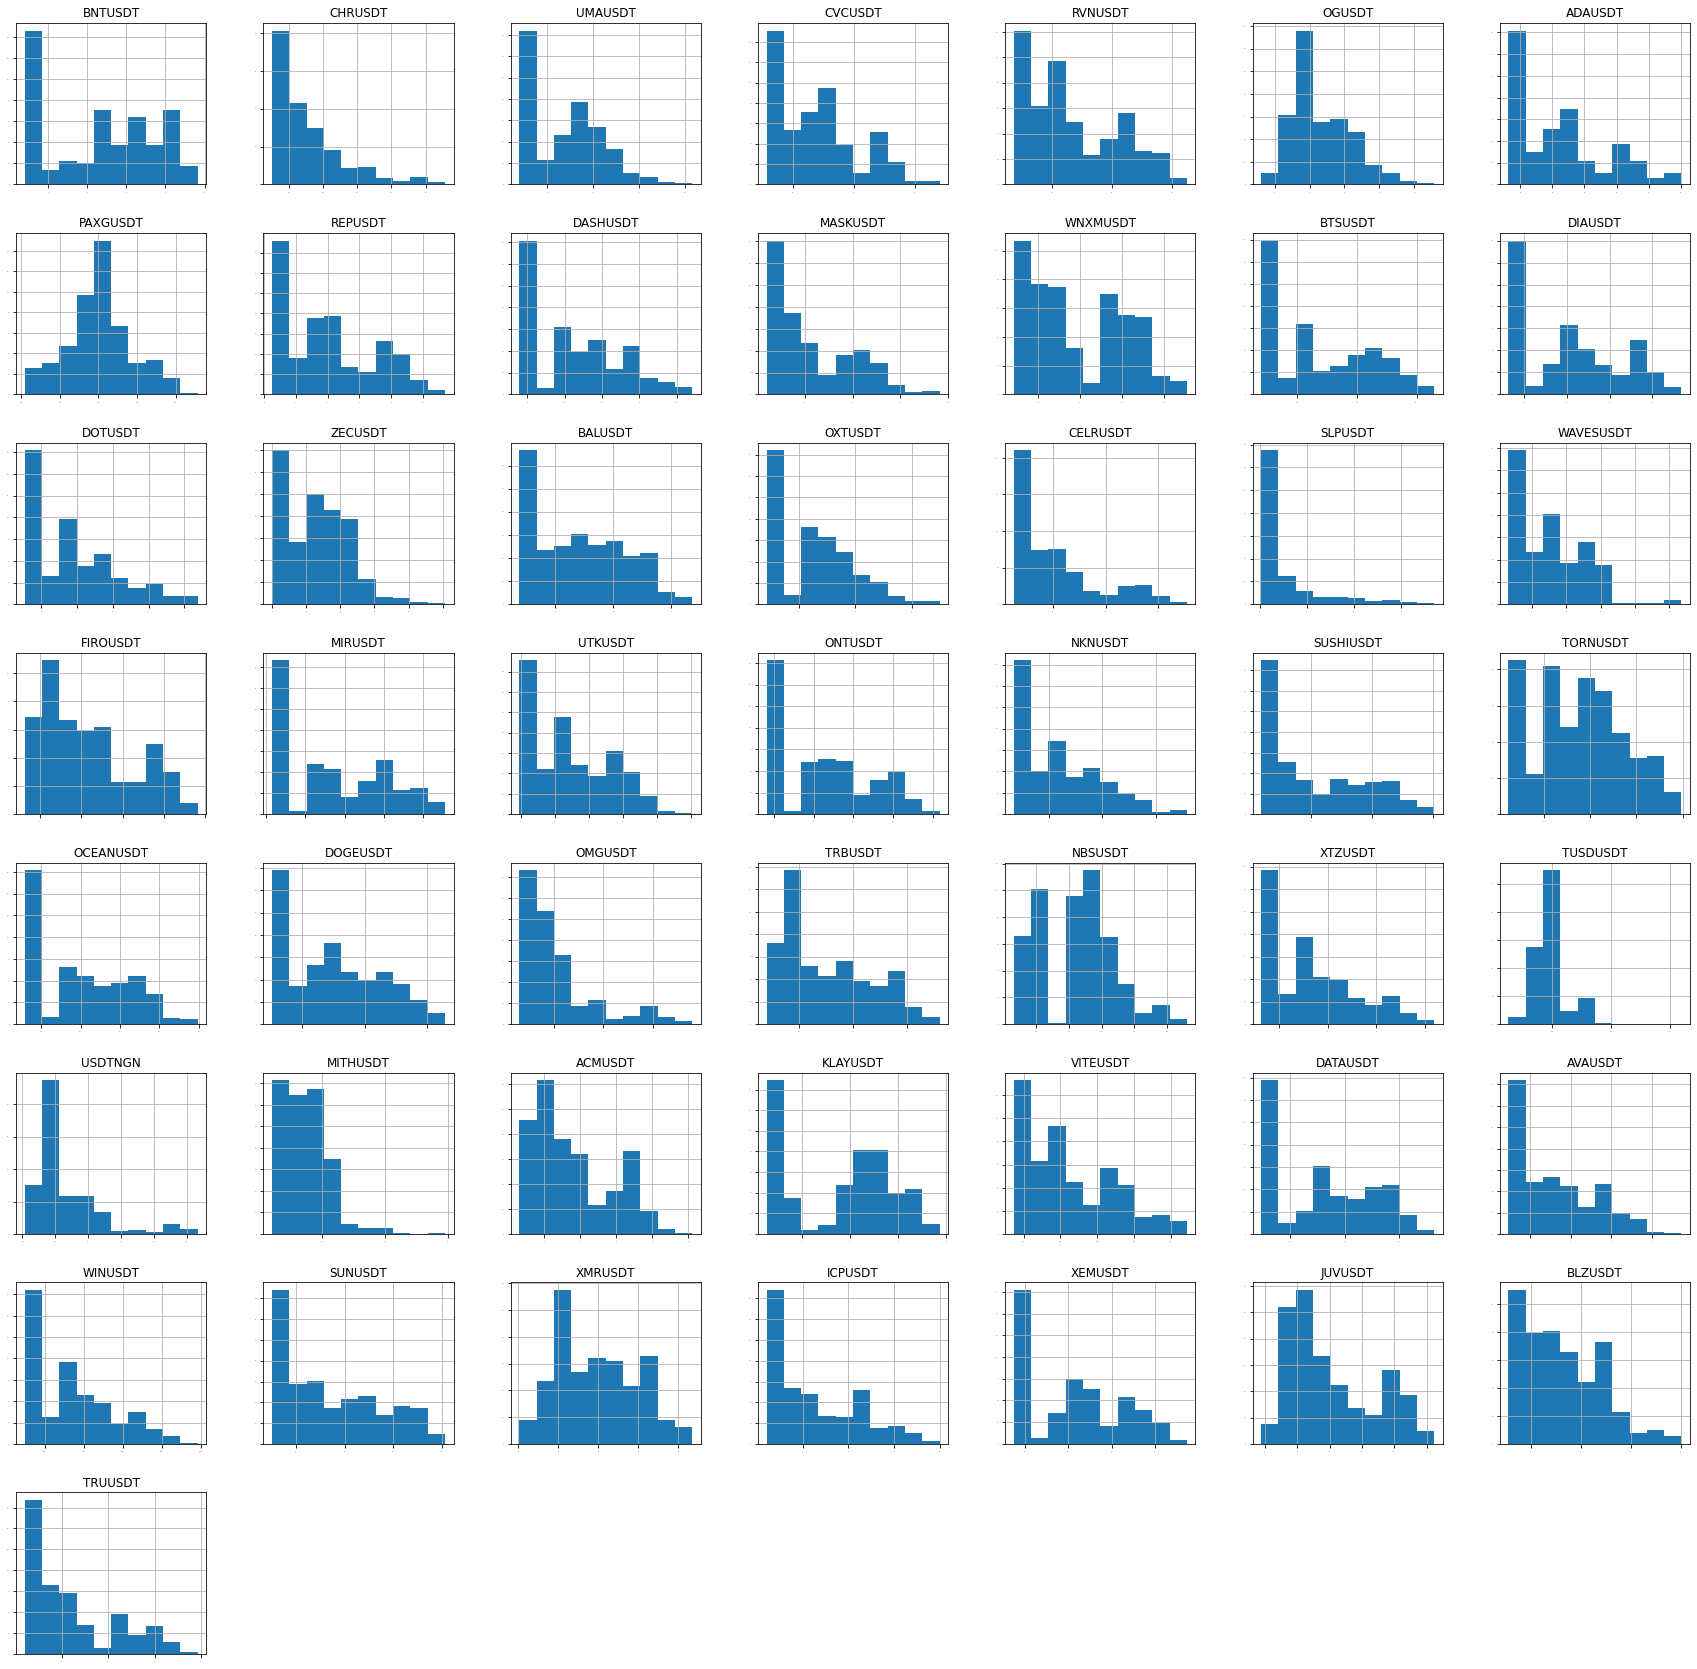

In [139]:
# histograms
data_subset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(30,30))
plt.show()

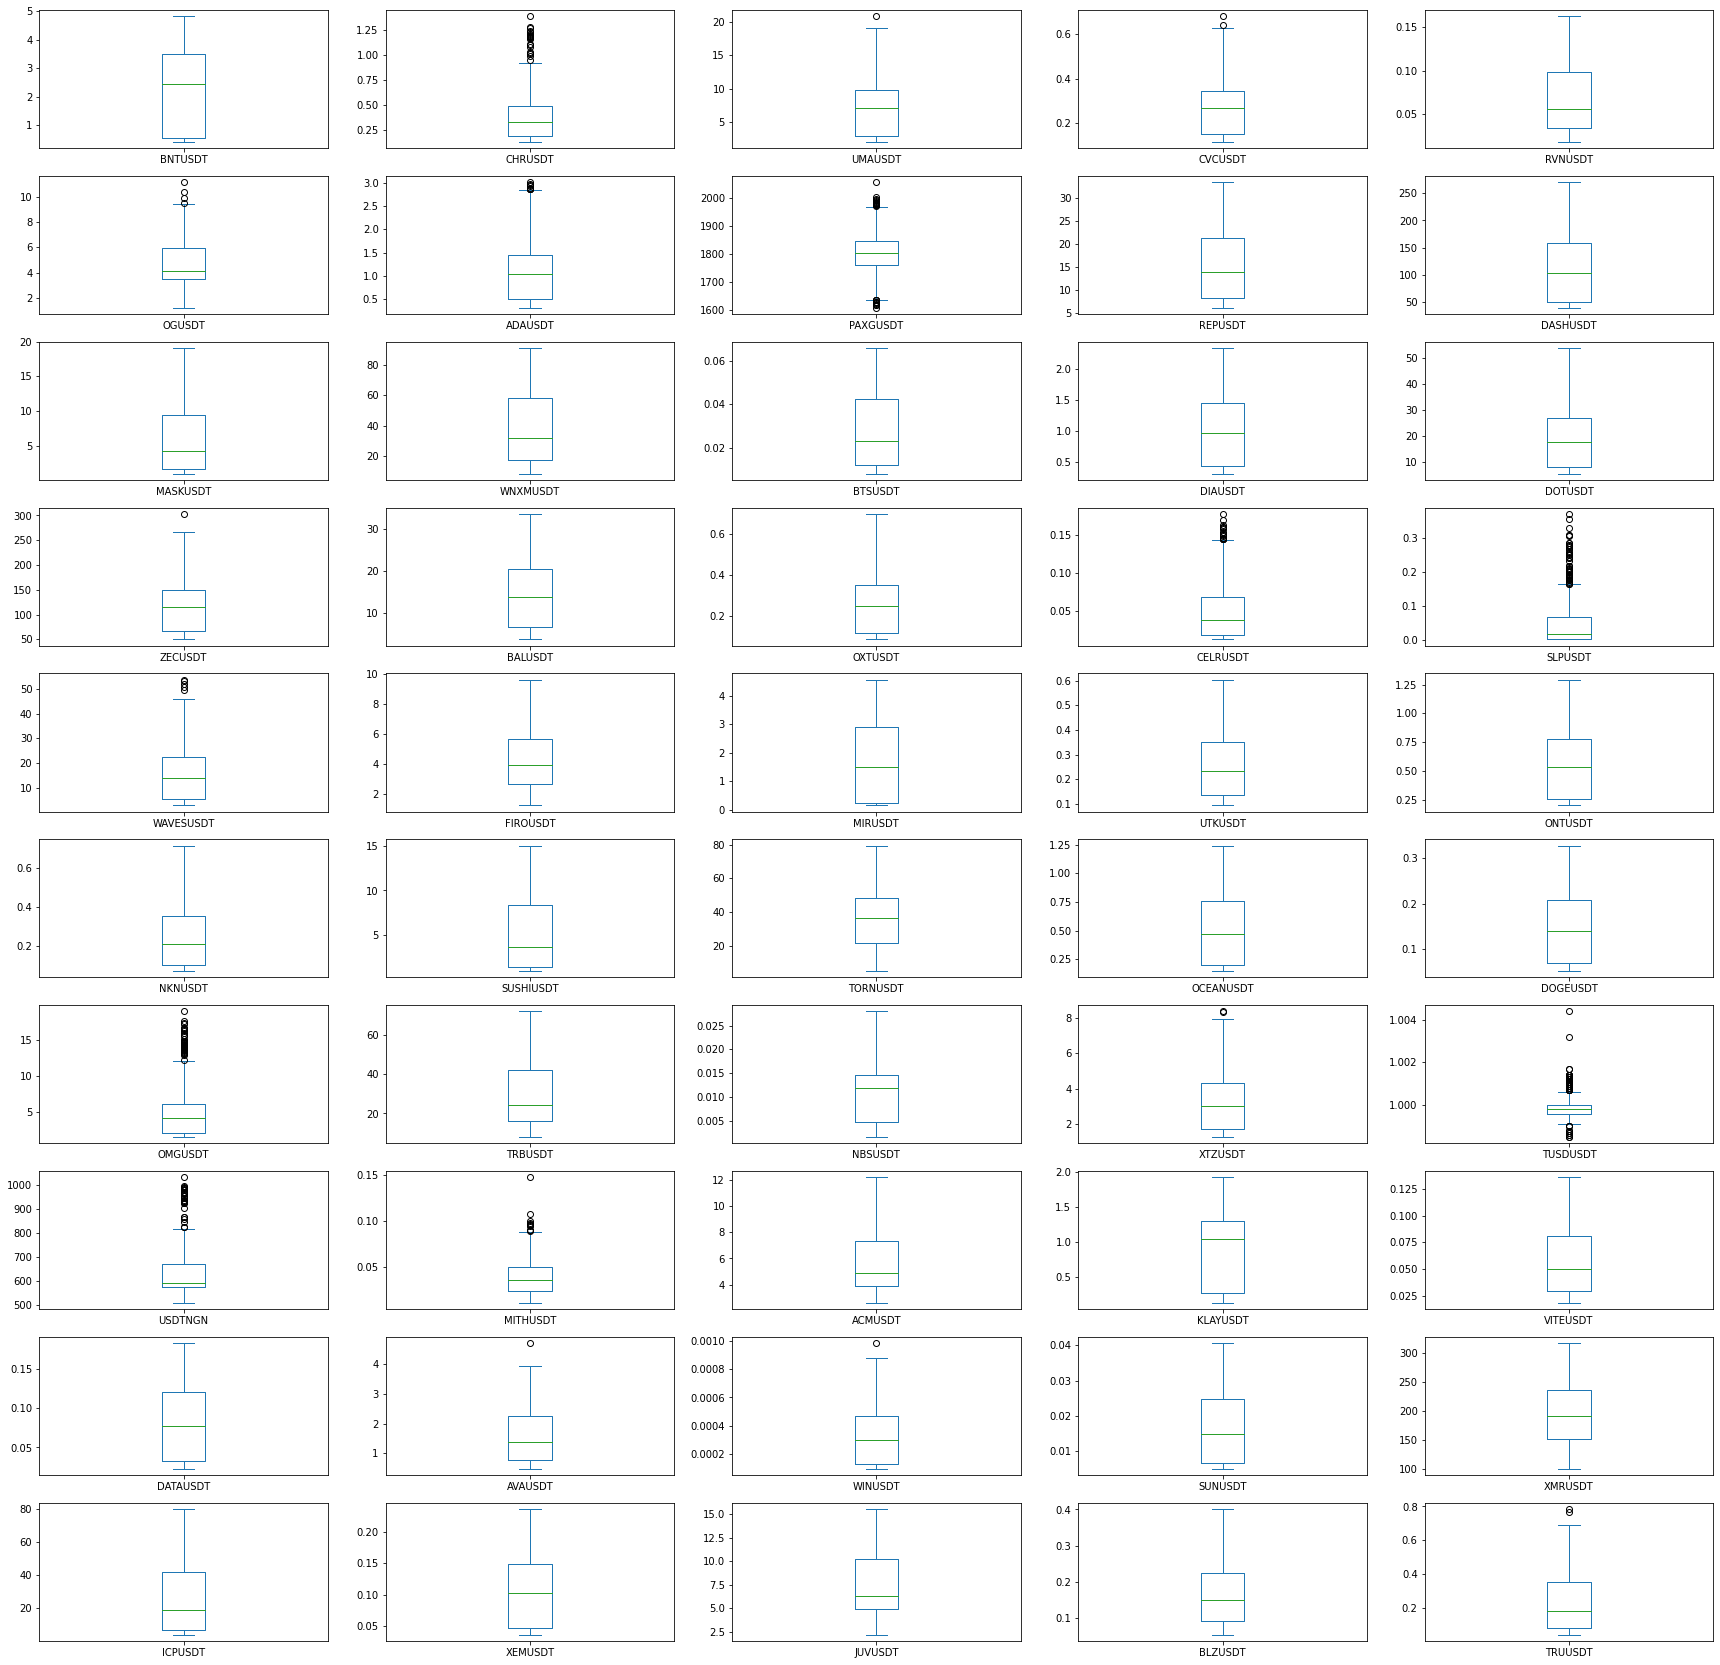

In [145]:
#Box and Whisker Plots
data_subset.plot(kind='box', subplots=True, sharex=False, layout=(10, 5),sharey=False, figsize=(30,30))
plt.show()

# 4. Data Preparation
In this step we will clean and transform our data to improve its quality prior to its use.
In the last step we worked with a subset of our data to perform visualization but from now on we will continue our work with the full dataset. 

## 4.1. Data cleaning.
Checking for the NAs in the rows, either drop them or fill them with the mean of the column.

In [147]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Our dataset contain some cryptocyrrencies with nan values. 
Lets find out which columns these are and how many values are nan. 

In [159]:
nan_cols = [i for i in dataset.columns if dataset[i].isnull().any()]
nan_cols

['LUNAUSDT']

In [161]:
dataset['LUNAUSDT'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: LUNAUSDT
Non-Null Count  Dtype  
--------------  -----  
483 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


The dataset has only one cryptocurrency with 13 nan values and we will carry out the forward filling method to eliminate these nan values.

In [163]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

In [193]:
#dataset.drop(columns=["LUNAUSDT"], inplace=True)

# 4.2. Data Transformation
Prepare the data for clustering. 

In [194]:
tp_year = round((len(dataset) / ((dataset.index[-1] - dataset.index[0])/ 365.25)), 2)

In [195]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = dataset.pct_change(axis='rows').mean(axis=0) * tp_year
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change(axis='rows').std(axis=0) * np.sqrt(tp_year)
data=returns

In [196]:
data.head()

,Returns,Volatility
DEGOUSDT,1.73e-01,1.42e+00
JUVUSDT,-7.98e-02,9.48e-01
USDTRUB,-6.34e-02,3.39e-01
USDTDAI,1.27e-03,6.81e-03
TUSDUSDT,3.81e-04,5.34e-03


In [197]:
data.describe()

,Returns,Volatility
count,237.00,2.37e+02
mean,0.24,1.25e+00
std,0.81,5.40e-01
min,-1.60,5.32e-03
25%,-0.23,1.06e+00
50%,0.07,1.21e+00
75%,0.54,1.45e+00
max,4.71,5.58e+00


All the variables should be on the same scale before applying PCA, otherwise a feature with large values will dominate the result. Below I use StandardScaler in scikit-learn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [198]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data), columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(5)

,Returns,Volatility
DEGOUSDT,-0.08,0.32
JUVUSDT,-0.39,-0.55
USDTRUB,-0.37,-1.68
USDTDAI,-0.29,-2.30
TUSDUSDT,-0.29,-2.30


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

# 5. Evaluate Algorithms and Models
We will look at the implementation and visualization of the following clustering techniques.

- KMeans

## 5.1. K-Means Clustering
**k-Means** is the most well-known clustering algorithm and was first proposed by Stuart Lloyd at Bell Labs in 1957.

The algorithm finds **K centroids** and assigns each data point to exactly one cluster with the goal of minimizing the within-cluster variance (called **inertia**). It typically uses **Euclidean distance** but other metrics can also be used. k-Means assumes that clusters are spherical and of equal size and ignores the covariance among features.

The problem is computationally difficult (np-hard) because there are 𝐾N ways to partition the N observations into K clusters. The standard iterative algorithm delivers a local optimum for a given K and proceeds as follows:

- Randomly define K cluster centers and assign points to nearest centroid
- Repeat:
    - For each cluster, compute the centroid as the average of the features
    - Assign each observation to the closest centroid
- Convergence: assignments (or within-cluster variation) don’t change

In [199]:
nclust=6

In [200]:
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=6)

Extract the important parameters from the k-means clustering

In [201]:
centroids, assignments, inertia = k_means.cluster_centers_, k_means.labels_, k_means.inertia_

In [202]:
#Extracting labels 
target_labels = k_means.predict(X)
#Printing the labels
target_labels

array([0, 0, 2, 2, 2, 5, 3, 0, 0, 5, 3, 0, 0, 0, 0, 0, 5, 3, 5, 5, 3, 1,
       1, 0, 0, 0, 3, 0, 0, 3, 1, 0, 5, 5, 0, 5, 0, 5, 0, 5, 0, 3, 0, 5,
       0, 0, 0, 3, 3, 5, 3, 1, 0, 3, 0, 1, 1, 3, 3, 0, 5, 0, 2, 3, 5, 3,
       3, 0, 5, 0, 0, 5, 5, 3, 0, 0, 0, 1, 0, 5, 2, 0, 0, 3, 3, 3, 3, 0,
       5, 1, 5, 2, 5, 3, 0, 0, 0, 3, 0, 3, 0, 5, 0, 3, 5, 5, 0, 3, 4, 0,
       0, 3, 3, 2, 3, 5, 0, 3, 3, 5, 0, 5, 1, 0, 3, 0, 0, 5, 0, 0, 5, 2,
       3, 0, 2, 0, 2, 0, 5, 0, 5, 1, 2, 0, 5, 0, 3, 5, 5, 0, 1, 0, 0, 0,
       0, 5, 5, 0, 1, 5, 3, 5, 3, 3, 2, 0, 4, 0, 1, 0, 5, 3, 0, 2, 5, 5,
       3, 5, 5, 2, 1, 0, 3, 0, 5, 5, 5, 0, 2, 0, 5, 0, 0, 0, 3, 3, 0, 1,
       5, 5, 5, 3, 0, 0, 5, 5, 0, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5,
       1, 0, 0, 5, 3, 5, 2, 5, 5, 2, 0, 3, 3, 0, 3, 3, 3], dtype=int32)

### 5.1.1. Finding optimal number of clusters
Typically, two metrics are used to evaluate a K-means model.

- Sum of square errors (SSE) within clusters
- Silhouette score.

**SSE** within clusters is derived by summing up the squared distance between each data point and its closest centroid. The goal is to reduce the error value. The intuition behind this is that we would want the distance of each data point to be as close as possible to the centroid. If the error is small, it would mean that the data points in the same cluster are relatively similar. As the number of centroids (clusters) increase, the error value will decrease. As such we would need to rely on the next metric to ensure that we are not introducing too many centroids (clusters) in the model.

**Silhouette** score is a measure of how similar the data point is to its own cluster compared to other clusters. The value ranges from -1 (worst score) to 1 (best score). A negative value would mean that data points are wrongly clustered while values near 0 would mean that there are overlapping clusters.

We will perform the SSE method.

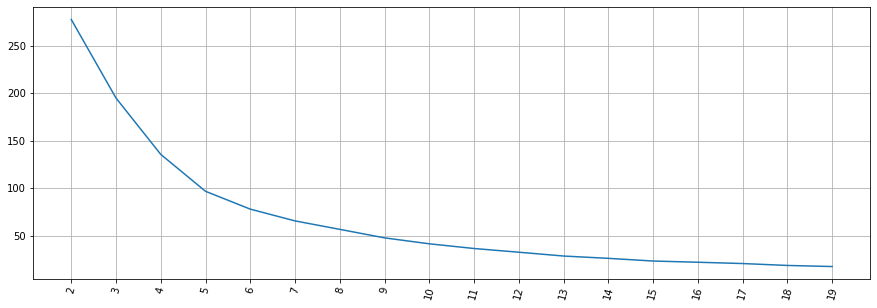

In [203]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans_test = KMeans(n_clusters=k)
    kmeans_test.fit(X)
    distorsions.append(kmeans_test.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

### 5.1.2. Cluster Visualisation
Visualizing how your clusters are formed is no easy task when the number of variables/dimensions in your dataset is very large. One of the methods of visualising a cluster in two-dimensional space.

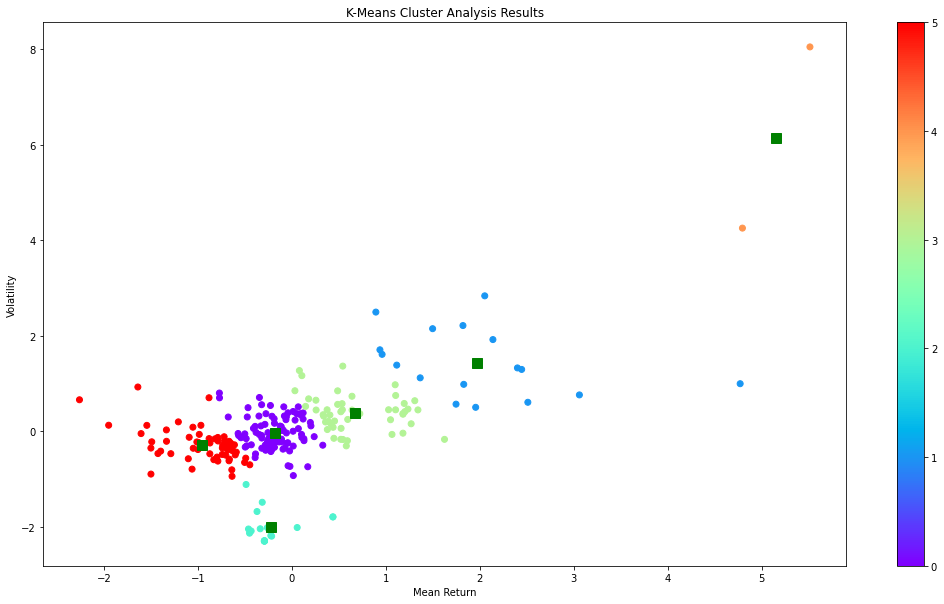

In [204]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [212]:
k_means.labels_

array([0, 0, 2, 2, 2, 5, 3, 0, 0, 5, 3, 0, 0, 0, 0, 0, 5, 3, 5, 5, 3, 1,
       1, 0, 0, 0, 3, 0, 0, 3, 1, 0, 5, 5, 0, 5, 0, 5, 0, 5, 0, 3, 0, 5,
       0, 0, 0, 3, 3, 5, 3, 1, 0, 3, 0, 1, 1, 3, 3, 0, 5, 0, 2, 3, 5, 3,
       3, 0, 5, 0, 0, 5, 5, 3, 0, 0, 0, 1, 0, 5, 2, 0, 0, 3, 3, 3, 3, 0,
       5, 1, 5, 2, 5, 3, 0, 0, 0, 3, 0, 3, 0, 5, 0, 3, 5, 5, 0, 3, 4, 0,
       0, 3, 3, 2, 3, 5, 0, 3, 3, 5, 0, 5, 1, 0, 3, 0, 0, 5, 0, 0, 5, 2,
       3, 0, 2, 0, 2, 0, 5, 0, 5, 1, 2, 0, 5, 0, 3, 5, 5, 0, 1, 0, 0, 0,
       0, 5, 5, 0, 1, 5, 3, 5, 3, 3, 2, 0, 4, 0, 1, 0, 5, 3, 0, 2, 5, 5,
       3, 5, 5, 2, 1, 0, 3, 0, 5, 5, 5, 0, 2, 0, 5, 0, 0, 0, 3, 3, 0, 1,
       5, 5, 5, 3, 0, 0, 5, 5, 0, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5,
       1, 0, 0, 5, 3, 5, 2, 5, 5, 2, 0, 3, 3, 0, 3, 3, 3], dtype=int32)

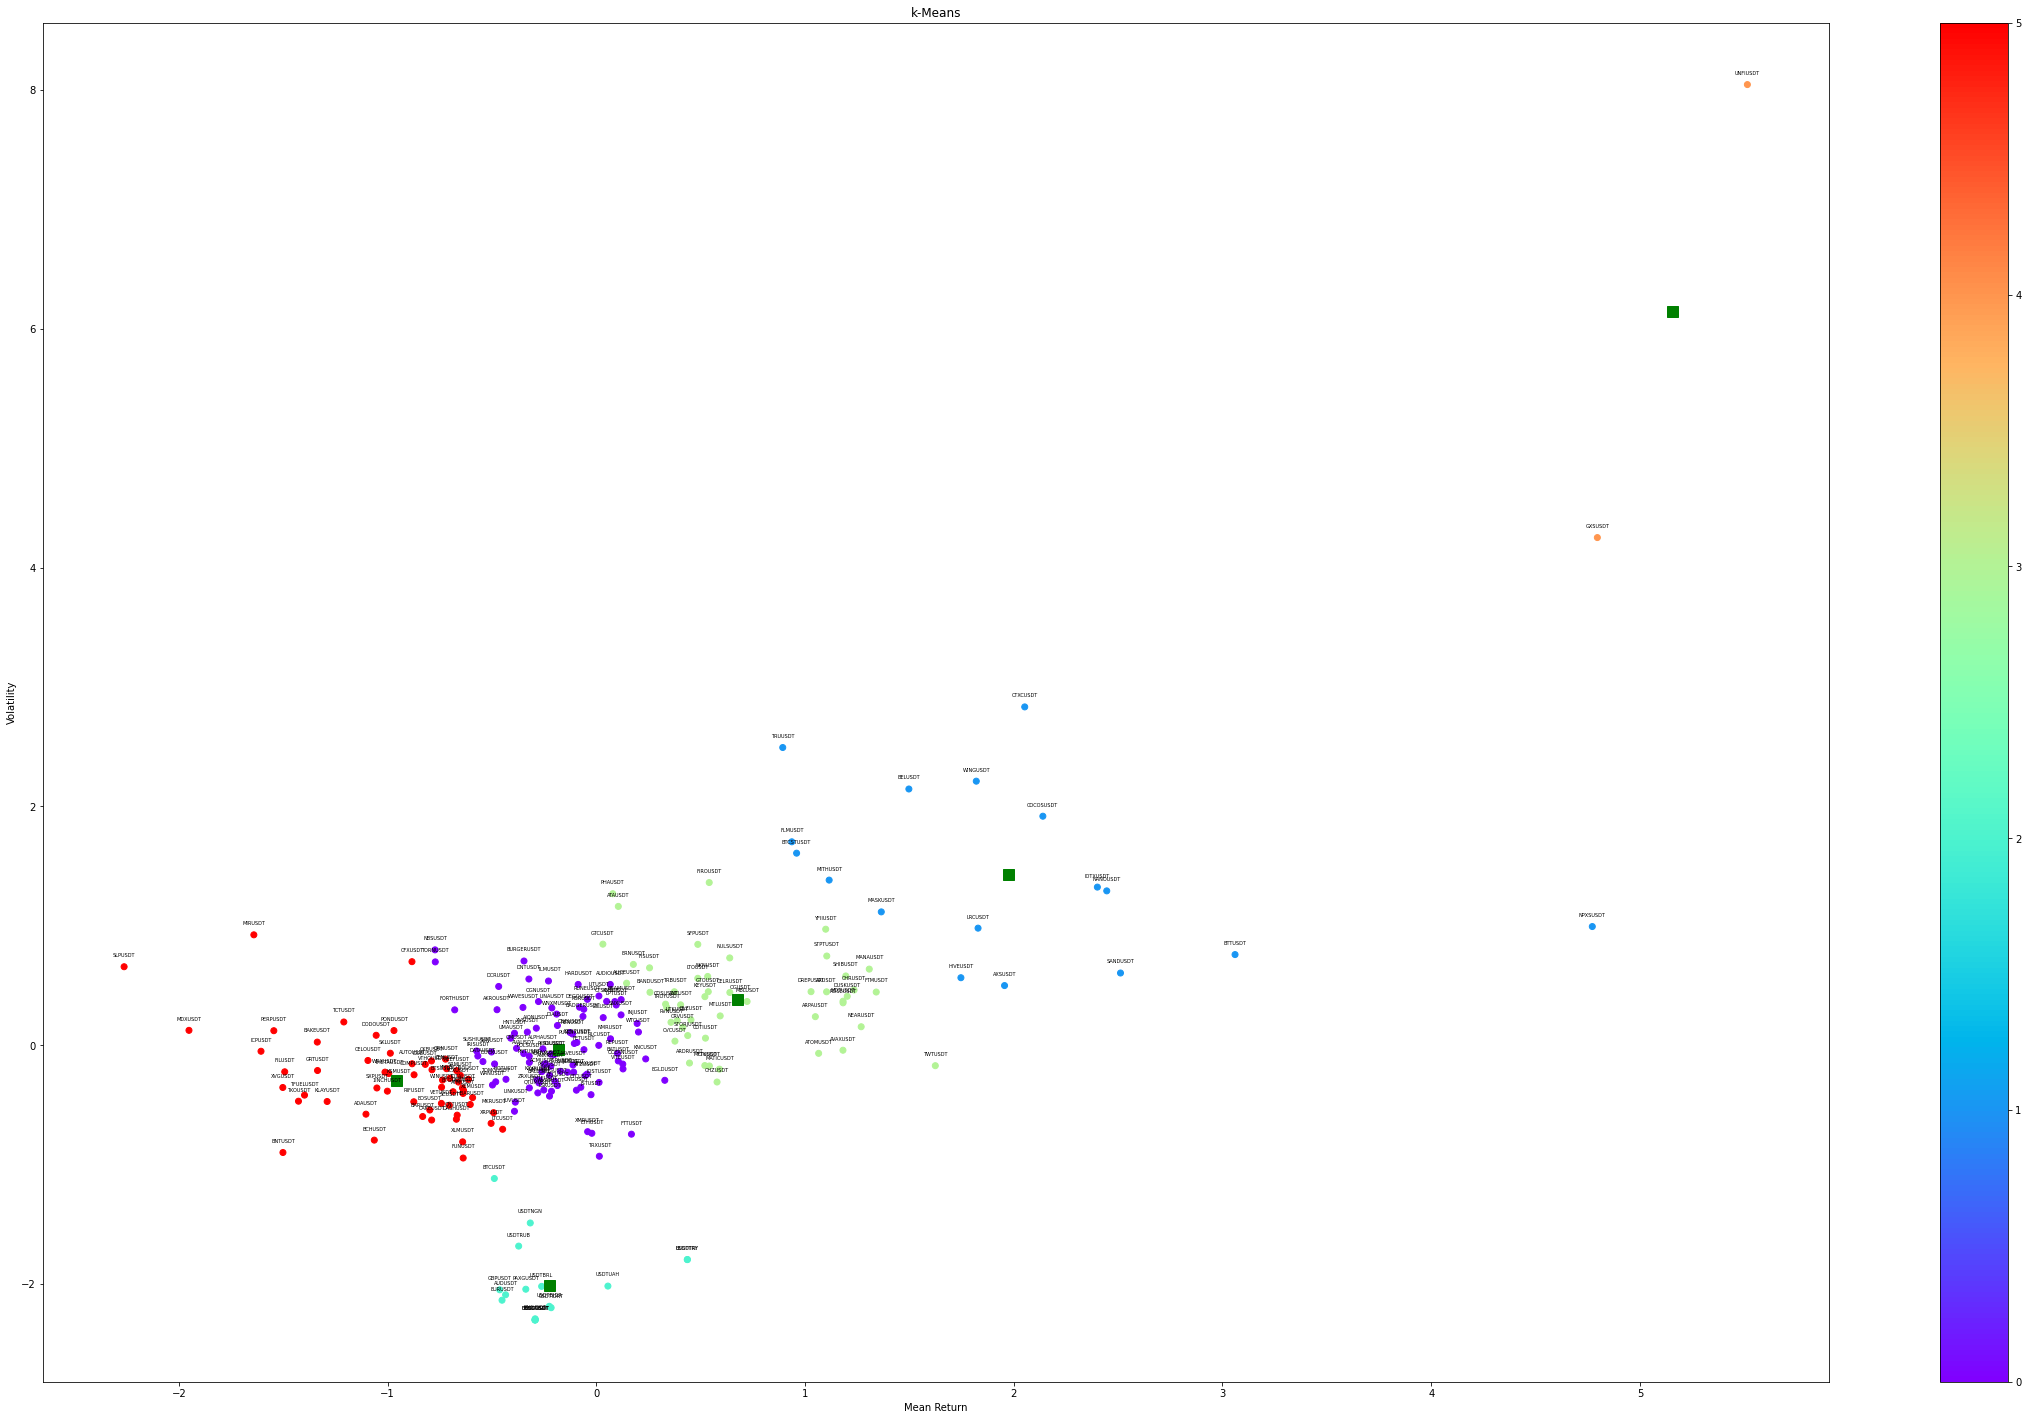

In [218]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(40,25))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 fontsize=5) # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)
plt.show()

Checking Elements in each cluster


In [227]:
cluster_label = pd.concat([pd.DataFrame(X.index), pd.DataFrame(k_means.labels_)],axis = 1)
cluster_label.columns =['Ticker','Cluster']
cluster_label.sort_values(by=['Cluster'])

,Ticker,Cluster
0,DEGOUSDT,0
95,OXTUSDT,0
94,DIAUSDT,0
172,TORNUSDT,0
87,XVSUSDT,0
...,...,...
177,ZENUSDT,5
90,YFIUSDT,5
175,CELOUSDT,5
199,RIFUSDT,5


# 6. Store clustered tickers


## 6.1 Randomly sample and store 5 tickers from each cluster for further backtesting with ML algorithms.


In [250]:
cluster_0_tickers = cluster_label[cluster_label['Cluster']==0].sample(n=5)["Ticker"].to_list()
cluster_1_tickers = cluster_label[cluster_label['Cluster']==1].sample(n=5)["Ticker"].to_list()
cluster_2_tickers = cluster_label[cluster_label['Cluster']==2].sample(n=5)["Ticker"].to_list()
cluster_3_tickers = cluster_label[cluster_label['Cluster']==3].sample(n=5)["Ticker"].to_list()

In [251]:
cluster_label[cluster_label['Cluster']==2].sample(n=5)["Ticker"].to_list()


['PAXUSDT', 'TUSDUSDT', 'USDTDAI', 'BUSDTRY', 'AUDUSDT']

In [252]:
cluster_0_tickers

['DNTUSDT', 'NBSUSDT', 'KMDUSDT', 'UMAUSDT', 'WANUSDT']

In [253]:
cluster_2_tickers

['USDTTRY', 'GBPUSDT', 'AUDUSDT', 'USDTUAH', 'USDCUSDT']

In [254]:
cluster_3_tickers

['STORJUSDT', 'TRBUSDT', 'SFPUSDT', 'ANTUSDT', 'BLZUSDT']

In [257]:
cluster_tickers = pd.DataFrame({"Cluster_0": cluster_0_tickers,
                                "Cluster_1": cluster_1_tickers,
                                "Cluster_2": cluster_2_tickers,
                                "Cluster_3": cluster_3_tickers,
                               })

In [259]:
cluster_tickers.to_csv("clustered_tickers.csv", index=False)